# Usage Behavior Analysis
**Phase 2.2: Analyze customer usage patterns and identify pre-churn behavior**

## Objectives:
1. Compare usage patterns: churned vs retained customers
2. Q1-Q2 vs Q3-Q4 usage trend analysis
3. Pre-churn usage decline patterns
4. Handle EU September data missing issue
5. Calculate key usage metrics (activity, engagement)
6. Identify churn early warning indicators


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("=" * 70)
print("Usage Behavior Analysis")
print("=" * 70)


Usage Behavior Analysis


## Step 1: Load Data


In [2]:
# Load merged dataset
df_merged = pd.read_csv('../dataset_merged_final.csv')
df_merged['contract_start_date'] = pd.to_datetime(df_merged['contract_start_date'])
df_merged['contract_end_date'] = pd.to_datetime(df_merged['contract_end_date'])

# Load raw usage logs for detailed analysis
df2a = pd.read_csv('../原始数据/dataset2a for q1 q2.csv')
df2b = pd.read_csv('../原始数据/dataset2b for q3 q4.csv')

print(f"Merged dataset: {len(df_merged)} customers")
print(f"Q1-Q2 usage logs: {len(df2a)} records")
print(f"Q3-Q4 usage logs: {len(df2b)} records")

# Check for EU September data corruption
if 'is_corrupted' in df2b.columns:
    corrupted_count = df2b['is_corrupted'].sum()
    print(f"\nEU September corrupted records: {corrupted_count}")


Merged dataset: 3000 customers
Q1-Q2 usage logs: 546000 records
Q3-Q4 usage logs: 552000 records


## Step 2: Define Churn Groups


In [3]:
# Define Q3 churned customers (contract ended + not renewed)
q3_start = pd.Timestamp('2024-07-01')
q3_end = pd.Timestamp('2024-09-30')

q3_churned = df_merged[
    (df_merged['contract_end_date'] >= q3_start) & 
    (df_merged['contract_end_date'] <= q3_end) & 
    (df_merged['renewed_flag'] == 0)
]

# Retained customers (not churned)
retained = df_merged[df_merged['is_churned'] == 0]

print(f"Q3 Churned Customers: {len(q3_churned)}")
print(f"Retained Customers: {len(retained)}")


Q3 Churned Customers: 550
Retained Customers: 2636


## Task 1: Compare Usage Patterns - Churned vs Retained


In [4]:
print("\n" + "=" * 70)
print("TASK 1: Compare Usage Patterns - Churned vs Retained")
print("=" * 70)

# Key usage metrics to compare
usage_metrics = [
    'total_logins',
    'avg_daily_logins',
    'active_days',
    'total_feature_events',
    'avg_feature_events',
    'total_session_minutes',
    'avg_session_minutes'
]

# Calculate statistics for each group
comparison_stats = []

for metric in usage_metrics:
    if metric in df_merged.columns:
        churned_mean = q3_churned[metric].mean()
        retained_mean = retained[metric].mean()
        difference = churned_mean - retained_mean
        pct_diff = (difference / retained_mean * 100) if retained_mean > 0 else 0
        
        comparison_stats.append({
            'Metric': metric,
            'Churned_Mean': churned_mean,
            'Retained_Mean': retained_mean,
            'Difference': difference,
            'Pct_Difference': pct_diff
        })

comparison_df = pd.DataFrame(comparison_stats)
print("\n--- Usage Metrics Comparison ---")
print(comparison_df.to_string(index=False))



TASK 1: Compare Usage Patterns - Churned vs Retained

--- Usage Metrics Comparison ---
               Metric  Churned_Mean  Retained_Mean   Difference  Pct_Difference
         total_logins    948.303636    1292.297041  -343.993405      -26.618757
     avg_daily_logins      2.740967       3.720733    -0.979766      -26.332611
          active_days    346.309091     347.323976    -1.014885       -0.292201
 total_feature_events    330.830909     452.094082  -121.263173      -26.822553
   avg_feature_events      0.956263       1.301686    -0.345422      -26.536533
total_session_minutes   4894.257724    7018.023227 -2123.765503      -30.261591
  avg_session_minutes     14.148661      20.203276    -6.054615      -29.968481



✓ Saved: usage_comparison_churned_vs_retained.png


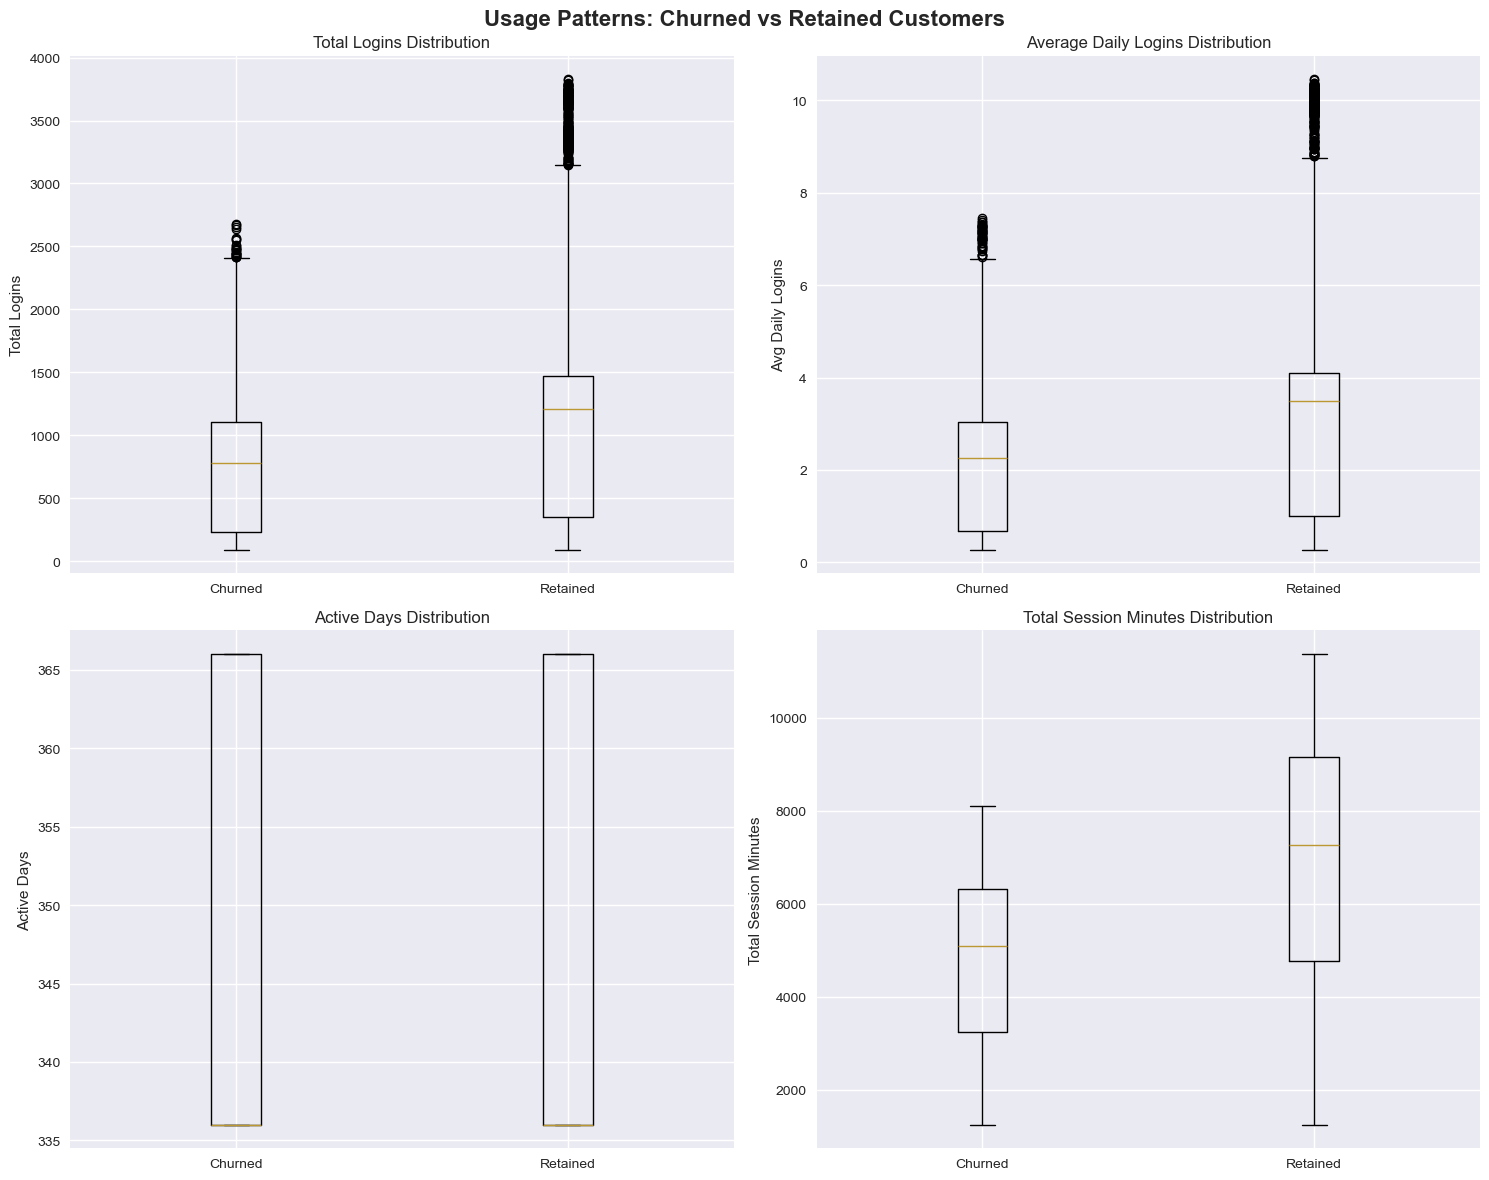

In [5]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Usage Patterns: Churned vs Retained Customers', fontsize=16, fontweight='bold')

# 1. Total Logins
axes[0, 0].boxplot([q3_churned['total_logins'].dropna(), retained['total_logins'].dropna()], 
                   labels=['Churned', 'Retained'])
axes[0, 0].set_title('Total Logins Distribution')
axes[0, 0].set_ylabel('Total Logins')

# 2. Average Daily Logins
axes[0, 1].boxplot([q3_churned['avg_daily_logins'].dropna(), retained['avg_daily_logins'].dropna()], 
                   labels=['Churned', 'Retained'])
axes[0, 1].set_title('Average Daily Logins Distribution')
axes[0, 1].set_ylabel('Avg Daily Logins')

# 3. Active Days
axes[1, 0].boxplot([q3_churned['active_days'].dropna(), retained['active_days'].dropna()], 
                   labels=['Churned', 'Retained'])
axes[1, 0].set_title('Active Days Distribution')
axes[1, 0].set_ylabel('Active Days')

# 4. Total Session Minutes
axes[1, 1].boxplot([q3_churned['total_session_minutes'].dropna(), retained['total_session_minutes'].dropna()], 
                   labels=['Churned', 'Retained'])
axes[1, 1].set_title('Total Session Minutes Distribution')
axes[1, 1].set_ylabel('Total Session Minutes')

plt.tight_layout()
plt.savefig('usage_comparison_churned_vs_retained.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: usage_comparison_churned_vs_retained.png")
plt.show()


## Task 2: Q1-Q2 vs Q3-Q4 Usage Trend Analysis


In [6]:
print("\n" + "=" * 70)
print("TASK 2: Q1-Q2 vs Q3-Q4 Usage Trend Analysis")
print("=" * 70)

# Compare Q1-Q2 vs Q3-Q4 usage for churned and retained customers
# For churned customers
churned_q1q2_logins = q3_churned['q1q2_logins'].mean()
churned_q3q4_logins = q3_churned['q3q4_logins'].mean()
churned_q1q2_minutes = q3_churned['q1q2_session_minutes'].mean()
churned_q3q4_minutes = q3_churned['q3q4_session_minutes'].mean()

# For retained customers
retained_q1q2_logins = retained['q1q2_logins'].mean()
retained_q3q4_logins = retained['q3q4_logins'].mean()
retained_q1q2_minutes = retained['q1q2_session_minutes'].mean()
retained_q3q4_minutes = retained['q3q4_session_minutes'].mean()

print("\n--- Usage Trend: Q1-Q2 vs Q3-Q4 ---")
print(f"\nChurned Customers:")
print(f"  Q1-Q2 Logins: {churned_q1q2_logins:.2f}")
print(f"  Q3-Q4 Logins: {churned_q3q4_logins:.2f}")
if churned_q1q2_logins > 0:
    print(f"  Change: {((churned_q3q4_logins / churned_q1q2_logins - 1) * 100):.1f}%")
print(f"  Q1-Q2 Session Minutes: {churned_q1q2_minutes:.2f}")
print(f"  Q3-Q4 Session Minutes: {churned_q3q4_minutes:.2f}")
if churned_q1q2_minutes > 0:
    print(f"  Change: {((churned_q3q4_minutes / churned_q1q2_minutes - 1) * 100):.1f}%")

print(f"\nRetained Customers:")
print(f"  Q1-Q2 Logins: {retained_q1q2_logins:.2f}")
print(f"  Q3-Q4 Logins: {retained_q3q4_logins:.2f}")
if retained_q1q2_logins > 0:
    print(f"  Change: {((retained_q3q4_logins / retained_q1q2_logins - 1) * 100):.1f}%")
print(f"  Q1-Q2 Session Minutes: {retained_q1q2_minutes:.2f}")
print(f"  Q3-Q4 Session Minutes: {retained_q3q4_minutes:.2f}")
if retained_q1q2_minutes > 0:
    print(f"  Change: {((retained_q3q4_minutes / retained_q1q2_minutes - 1) * 100):.1f}%")



TASK 2: Q1-Q2 vs Q3-Q4 Usage Trend Analysis

--- Usage Trend: Q1-Q2 vs Q3-Q4 ---

Churned Customers:
  Q1-Q2 Logins: 749.65
  Q3-Q4 Logins: 198.65
  Change: -73.5%
  Q1-Q2 Session Minutes: 3852.81
  Q3-Q4 Session Minutes: 1041.45
  Change: -73.0%

Retained Customers:
  Q1-Q2 Logins: 730.94
  Q3-Q4 Logins: 561.36
  Change: -23.2%
  Q1-Q2 Session Minutes: 3949.87
  Q3-Q4 Session Minutes: 3068.16
  Change: -22.3%



✓ Saved: usage_trend_q1q2_vs_q3q4.png


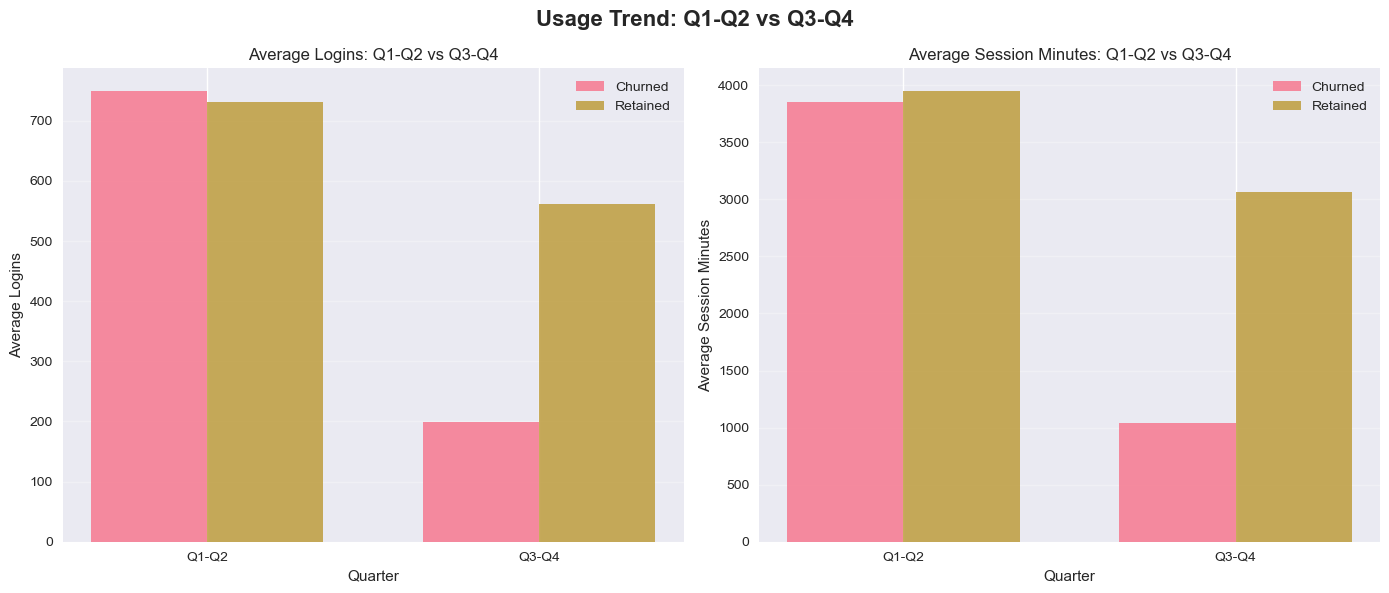

In [7]:
# Visualize Q1-Q2 vs Q3-Q4 trends
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Usage Trend: Q1-Q2 vs Q3-Q4', fontsize=16, fontweight='bold')

# Logins trend
quarters = ['Q1-Q2', 'Q3-Q4']
churned_logins = [churned_q1q2_logins, churned_q3q4_logins]
retained_logins = [retained_q1q2_logins, retained_q3q4_logins]

x = np.arange(len(quarters))
width = 0.35

axes[0].bar(x - width/2, churned_logins, width, label='Churned', alpha=0.8)
axes[0].bar(x + width/2, retained_logins, width, label='Retained', alpha=0.8)
axes[0].set_xlabel('Quarter')
axes[0].set_ylabel('Average Logins')
axes[0].set_title('Average Logins: Q1-Q2 vs Q3-Q4')
axes[0].set_xticks(x)
axes[0].set_xticklabels(quarters)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Session minutes trend
churned_minutes = [churned_q1q2_minutes, churned_q3q4_minutes]
retained_minutes = [retained_q1q2_minutes, retained_q3q4_minutes]

axes[1].bar(x - width/2, churned_minutes, width, label='Churned', alpha=0.8)
axes[1].bar(x + width/2, retained_minutes, width, label='Retained', alpha=0.8)
axes[1].set_xlabel('Quarter')
axes[1].set_ylabel('Average Session Minutes')
axes[1].set_title('Average Session Minutes: Q1-Q2 vs Q3-Q4')
axes[1].set_xticks(x)
axes[1].set_xticklabels(quarters)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('usage_trend_q1q2_vs_q3q4.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: usage_trend_q1q2_vs_q3q4.png")
plt.show()


## Task 3: Pre-Churn Usage Decline Patterns


In [8]:
print("\n" + "=" * 70)
print("TASK 3: Pre-Churn Usage Decline Patterns")
print("=" * 70)

# Analyze usage decline for churned customers
# Calculate usage change percentage
q3_churned_with_data = q3_churned[
    (q3_churned['q1q2_logins'].notna()) & 
    (q3_churned['q3q4_logins'].notna()) &
    (q3_churned['q1q2_logins'] > 0)
].copy()

if len(q3_churned_with_data) > 0:
    q3_churned_with_data['login_change_pct'] = (
        (q3_churned_with_data['q3q4_logins'] - q3_churned_with_data['q1q2_logins']) /
        q3_churned_with_data['q1q2_logins'] * 100
    )
    
    q3_churned_with_data['minutes_change_pct'] = (
        (q3_churned_with_data['q3q4_session_minutes'] - q3_churned_with_data['q1q2_session_minutes']) /
        q3_churned_with_data['q1q2_session_minutes'] * 100
    )
    
    print(f"\n--- Pre-Churn Usage Decline Analysis ---")
    print(f"Customers with usage data: {len(q3_churned_with_data)}")
    print(f"\nLogin Change Statistics:")
    print(f"  Mean change: {q3_churned_with_data['login_change_pct'].mean():.1f}%")
    print(f"  Median change: {q3_churned_with_data['login_change_pct'].median():.1f}%")
    print(f"  Customers with decline: {(q3_churned_with_data['login_change_pct'] < 0).sum()} ({(q3_churned_with_data['login_change_pct'] < 0).sum() / len(q3_churned_with_data) * 100:.1f}%)")
    print(f"  Customers with >50% decline: {(q3_churned_with_data['login_change_pct'] < -50).sum()} ({(q3_churned_with_data['login_change_pct'] < -50).sum() / len(q3_churned_with_data) * 100:.1f}%)")
    
    print(f"\nSession Minutes Change Statistics:")
    print(f"  Mean change: {q3_churned_with_data['minutes_change_pct'].mean():.1f}%")
    print(f"  Median change: {q3_churned_with_data['minutes_change_pct'].median():.1f}%")
    print(f"  Customers with decline: {(q3_churned_with_data['minutes_change_pct'] < 0).sum()} ({(q3_churned_with_data['minutes_change_pct'] < 0).sum() / len(q3_churned_with_data) * 100:.1f}%)")
    print(f"  Customers with >50% decline: {(q3_churned_with_data['minutes_change_pct'] < -50).sum()} ({(q3_churned_with_data['minutes_change_pct'] < -50).sum() / len(q3_churned_with_data) * 100:.1f}%)")
else:
    print("\nNo sufficient data for pre-churn analysis")



TASK 3: Pre-Churn Usage Decline Patterns

--- Pre-Churn Usage Decline Analysis ---
Customers with usage data: 550

Login Change Statistics:
  Mean change: -70.8%
  Median change: -71.7%
  Customers with decline: 547 (99.5%)
  Customers with >50% decline: 467 (84.9%)

Session Minutes Change Statistics:
  Mean change: -70.7%
  Median change: -71.6%
  Customers with decline: 549 (99.8%)
  Customers with >50% decline: 467 (84.9%)



✓ Saved: pre_churn_usage_decline_patterns.png


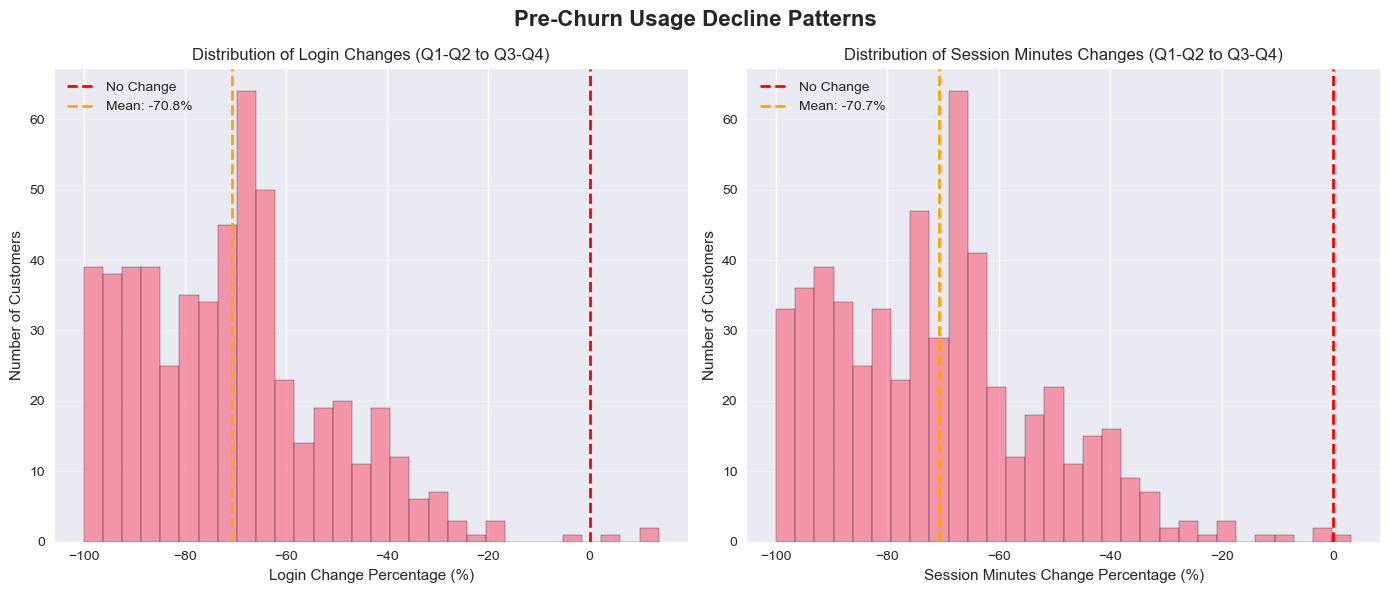

In [9]:
# Visualize usage decline patterns
if len(q3_churned_with_data) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Pre-Churn Usage Decline Patterns', fontsize=16, fontweight='bold')
    
    # Login change distribution
    axes[0].hist(q3_churned_with_data['login_change_pct'], bins=30, edgecolor='black', alpha=0.7)
    axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='No Change')
    axes[0].axvline(q3_churned_with_data['login_change_pct'].mean(), color='orange', 
                   linestyle='--', linewidth=2, label=f'Mean: {q3_churned_with_data["login_change_pct"].mean():.1f}%')
    axes[0].set_xlabel('Login Change Percentage (%)')
    axes[0].set_ylabel('Number of Customers')
    axes[0].set_title('Distribution of Login Changes (Q1-Q2 to Q3-Q4)')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # Session minutes change distribution
    axes[1].hist(q3_churned_with_data['minutes_change_pct'], bins=30, edgecolor='black', alpha=0.7)
    axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='No Change')
    axes[1].axvline(q3_churned_with_data['minutes_change_pct'].mean(), color='orange', 
                   linestyle='--', linewidth=2, label=f'Mean: {q3_churned_with_data["minutes_change_pct"].mean():.1f}%')
    axes[1].set_xlabel('Session Minutes Change Percentage (%)')
    axes[1].set_ylabel('Number of Customers')
    axes[1].set_title('Distribution of Session Minutes Changes (Q1-Q2 to Q3-Q4)')
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('pre_churn_usage_decline_patterns.png', dpi=300, bbox_inches='tight')
    print("\n✓ Saved: pre_churn_usage_decline_patterns.png")
    plt.show()


## Task 4: Handle EU September Data Missing Issue


In [10]:
print("\n" + "=" * 70)
print("TASK 4: Handle EU September Data Missing Issue")
print("=" * 70)

# Check EU September data corruption
if 'is_corrupted' in df2b.columns:
    eu_sept_corrupted = df2b[(df2b['is_eu'] == 1) & (df2b['is_corrupted'] == 1)]
    print(f"\nEU September Corrupted Records: {len(eu_sept_corrupted)}")
    
    # Identify affected customers
    affected_customers = eu_sept_corrupted['customer_id'].unique()
    print(f"Affected EU Customers: {len(affected_customers)}")
    
    # Check impact on Q3 churned customers
    eu_q3_churned = q3_churned[q3_churned['is_eu'] == 1]
    eu_q3_churned_affected = eu_q3_churned[eu_q3_churned['customer_id'].isin(affected_customers)]
    
    print(f"\n--- Impact on Analysis ---")
    print(f"EU Q3 Churned Customers: {len(eu_q3_churned)}")
    print(f"EU Q3 Churned with Corrupted Data: {len(eu_q3_churned_affected)}")
    print(f"Impact: {len(eu_q3_churned_affected) / len(eu_q3_churned) * 100:.1f}% of EU Q3 churned customers")
    
    print(f"\n--- Recommendation ---")
    print("Note: EU September data corruption may affect Q3-Q4 usage metrics.")
    print("Consider excluding corrupted records or using Q1-Q2 data for comparison.")
else:
    print("\nNo corruption flag found in dataset2b. Checking for missing data...")
    
    # Check for missing September data
    if 'date' in df2b.columns:
        df2b['date'] = pd.to_datetime(df2b['date'])
        sept_2024 = df2b[(df2b['date'] >= '2024-09-01') & (df2b['date'] < '2024-10-01')]
        if 'is_eu' in df2b.columns:
            eu_sept = sept_2024[sept_2024['is_eu'] == 1]
            print(f"September 2024 records: {len(sept_2024)}")
            print(f"EU September 2024 records: {len(eu_sept)}")



TASK 4: Handle EU September Data Missing Issue

No corruption flag found in dataset2b. Checking for missing data...


## Task 5: Calculate Key Usage Metrics (Activity, Engagement)


In [12]:
print("\n" + "=" * 70)
print("TASK 5: Calculate Key Usage Metrics (Activity, Engagement)")
print("=" * 70)

# Calculate engagement score (composite metric)
def calculate_engagement_score(row):
    """Calculate engagement score based on multiple usage metrics"""
    score = 0
    
    # Normalize metrics (0-1 scale)
    if pd.notna(row['avg_daily_logins']):
        # Assuming max avg_daily_logins is around 10
        score += min(row['avg_daily_logins'] / 10, 1.0) * 0.3
    
    if pd.notna(row['active_days']):
        # Assuming max active_days is 366
        score += min(row['active_days'] / 366, 1.0) * 0.3
    
    if pd.notna(row['avg_feature_events']):
        # Assuming max avg_feature_events is around 5
        score += min(row['avg_feature_events'] / 5, 1.0) * 0.2
    
    if pd.notna(row['avg_session_minutes']):
        # Assuming max avg_session_minutes is around 60
        score += min(row['avg_session_minutes'] / 60, 1.0) * 0.2
    
    return score * 100  # Scale to 0-100

# Apply engagement score
df_merged['engagement_score'] = df_merged.apply(calculate_engagement_score, axis=1)

# Calculate activity level categories
def categorize_activity(row):
    """Categorize customers by activity level"""
    if pd.isna(row['avg_daily_logins']) or row['avg_daily_logins'] == 0:
        return 'Inactive'
    elif row['avg_daily_logins'] < 1:
        return 'Low'
    elif row['avg_daily_logins'] < 3:
        return 'Medium'
    else:
        return 'High'

df_merged['activity_level'] = df_merged.apply(categorize_activity, axis=1)

# Re-define q3_churned and retained to include new columns
q3_churned = df_merged[
    (df_merged['contract_end_date'] >= q3_start) & 
    (df_merged['contract_end_date'] <= q3_end) & 
    (df_merged['renewed_flag'] == 0)
]

retained = df_merged[df_merged['is_churned'] == 0]

# Compare metrics for churned vs retained
print("\n--- Key Usage Metrics Summary ---")
print(f"\nChurned Customers:")
print(f"  Average Engagement Score: {q3_churned['engagement_score'].mean():.2f}")
print(f"  Activity Level Distribution:")
print(q3_churned['activity_level'].value_counts().to_string())

print(f"\nRetained Customers:")
print(f"  Average Engagement Score: {retained['engagement_score'].mean():.2f}")
print(f"  Activity Level Distribution:")
print(retained['activity_level'].value_counts().to_string())



TASK 5: Calculate Key Usage Metrics (Activity, Engagement)

--- Key Usage Metrics Summary ---

Churned Customers:
  Average Engagement Score: 45.15
  Activity Level Distribution:
activity_level
Medium    234
Low       172
High      144

Retained Customers:
  Average Engagement Score: 51.55
  Activity Level Distribution:
activity_level
High      1474
Low        635
Medium     527



✓ Saved: engagement_score_analysis.png


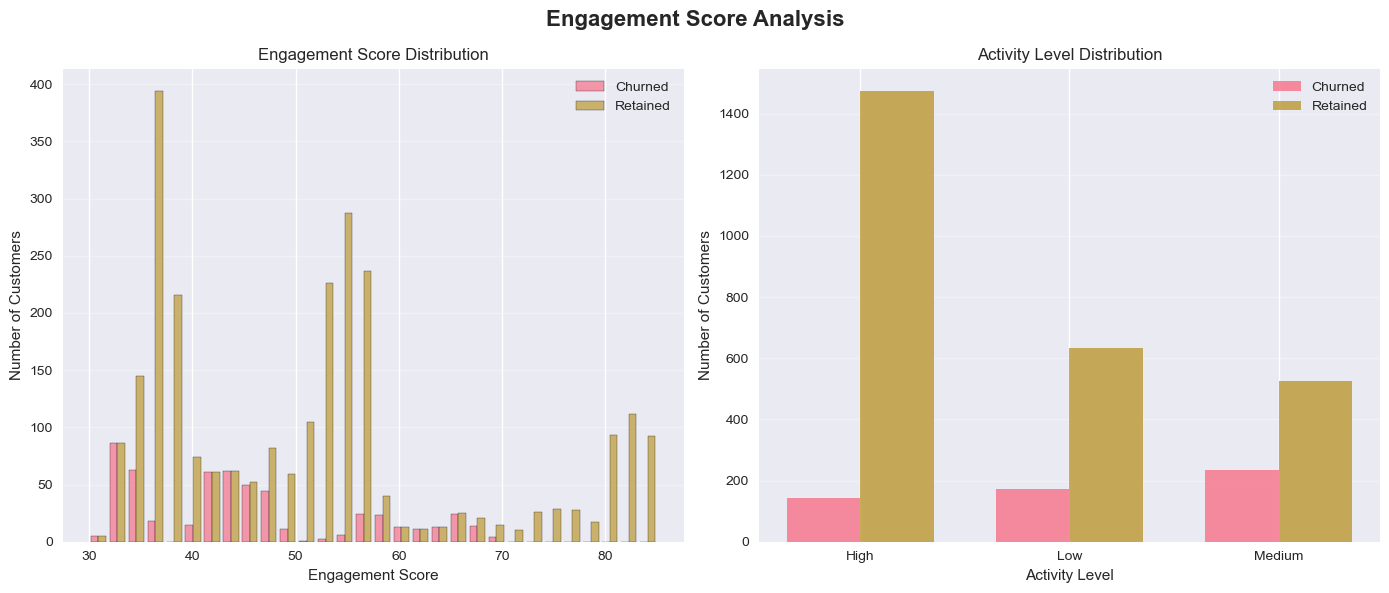

In [13]:
# Visualize engagement scores
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Engagement Score Analysis', fontsize=16, fontweight='bold')

# Engagement score distribution
axes[0].hist([q3_churned['engagement_score'].dropna(), retained['engagement_score'].dropna()], 
            bins=30, label=['Churned', 'Retained'], alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Engagement Score')
axes[0].set_ylabel('Number of Customers')
axes[0].set_title('Engagement Score Distribution')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Activity level comparison
activity_churned = q3_churned['activity_level'].value_counts().sort_index()
activity_retained = retained['activity_level'].value_counts().sort_index()

x = np.arange(len(activity_churned.index))
width = 0.35

axes[1].bar(x - width/2, activity_churned.values, width, label='Churned', alpha=0.8)
axes[1].bar(x + width/2, activity_retained.values, width, label='Retained', alpha=0.8)
axes[1].set_xlabel('Activity Level')
axes[1].set_ylabel('Number of Customers')
axes[1].set_title('Activity Level Distribution')
axes[1].set_xticks(x)
axes[1].set_xticklabels(activity_churned.index)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('engagement_score_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: engagement_score_analysis.png")
plt.show()


## Task 6: Churn Early Warning Indicators


In [14]:
print("\n" + "=" * 70)
print("TASK 6: Churn Early Warning Indicators")
print("=" * 70)

# Identify early warning indicators
warning_indicators = []

# 1. Usage decline >50%
if len(q3_churned_with_data) > 0:
    severe_decline = q3_churned_with_data[q3_churned_with_data['login_change_pct'] < -50]
    warning_indicators.append({
        'Indicator': 'Usage Decline >50%',
        'Count': len(severe_decline),
        'Percentage': len(severe_decline) / len(q3_churned_with_data) * 100
    })

# 2. Low engagement score
low_engagement = q3_churned[q3_churned['engagement_score'] < 30]
warning_indicators.append({
    'Indicator': 'Low Engagement Score (<30)',
    'Count': len(low_engagement),
    'Percentage': len(low_engagement) / len(q3_churned) * 100
})

# 3. Inactive or low activity
inactive_low = q3_churned[q3_churned['activity_level'].isin(['Inactive', 'Low'])]
warning_indicators.append({
    'Indicator': 'Inactive/Low Activity',
    'Count': len(inactive_low),
    'Percentage': len(inactive_low) / len(q3_churned) * 100
})

# 4. Zero Q3-Q4 usage
zero_q3q4 = q3_churned[(q3_churned['q3q4_logins'].notna()) & (q3_churned['q3q4_logins'] == 0)]
warning_indicators.append({
    'Indicator': 'Zero Q3-Q4 Usage',
    'Count': len(zero_q3q4),
    'Percentage': len(zero_q3q4) / len(q3_churned) * 100
})

indicators_df = pd.DataFrame(warning_indicators)
print("\n--- Early Warning Indicators for Churn ---")
print(indicators_df.to_string(index=False))

# Save indicators
indicators_df.to_csv('churn_early_warning_indicators.csv', index=False)
print("\n✓ Saved: churn_early_warning_indicators.csv")



TASK 6: Churn Early Warning Indicators

--- Early Warning Indicators for Churn ---
                 Indicator  Count  Percentage
        Usage Decline >50%    467   84.909091
Low Engagement Score (<30)      1    0.181818
     Inactive/Low Activity    172   31.272727
          Zero Q3-Q4 Usage      1    0.181818

✓ Saved: churn_early_warning_indicators.csv


## Generate Summary Report


In [15]:
# Create comprehensive summary report
summary = []
summary.append("=" * 70)
summary.append("Usage Behavior Analysis Report")
summary.append("=" * 70)
summary.append(f"\nGenerated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
summary.append("\n")

summary.append("1. KEY FINDINGS")
summary.append("-" * 70)
summary.append(f"Q3 Churned Customers: {len(q3_churned)}")
summary.append(f"Retained Customers: {len(retained)}")
summary.append("\n")

summary.append("2. USAGE PATTERNS COMPARISON")
summary.append("-" * 70)
for _, row in comparison_df.iterrows():
    summary.append(f"{row['Metric']}:")
    summary.append(f"  Churned: {row['Churned_Mean']:.2f}")
    summary.append(f"  Retained: {row['Retained_Mean']:.2f}")
    summary.append(f"  Difference: {row['Pct_Difference']:.1f}%")
summary.append("\n")

summary.append("3. Q1-Q2 vs Q3-Q4 TREND")
summary.append("-" * 70)
summary.append(f"Churned Customers:")
summary.append(f"  Q1-Q2 Logins: {churned_q1q2_logins:.2f}")
summary.append(f"  Q3-Q4 Logins: {churned_q3q4_logins:.2f}")
summary.append(f"Retained Customers:")
summary.append(f"  Q1-Q2 Logins: {retained_q1q2_logins:.2f}")
summary.append(f"  Q3-Q4 Logins: {retained_q3q4_logins:.2f}")
summary.append("\n")

summary.append("4. EARLY WARNING INDICATORS")
summary.append("-" * 70)
for _, row in indicators_df.iterrows():
    summary.append(f"{row['Indicator']}: {row['Count']} customers ({row['Percentage']:.1f}%)")
summary.append("\n")

summary.append("=" * 70)

with open('usage_behavior_analysis_report.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(summary))

print("\n" + "=" * 70)
print("Analysis Complete!")
print("=" * 70)
print("\nGenerated Files:")
print("  1. usage_comparison_churned_vs_retained.png")
print("  2. usage_trend_q1q2_vs_q3q4.png")
print("  3. pre_churn_usage_decline_patterns.png")
print("  4. engagement_score_analysis.png")
print("  5. churn_early_warning_indicators.csv")
print("  6. usage_behavior_analysis_report.txt")
print("=" * 70)



Analysis Complete!

Generated Files:
  1. usage_comparison_churned_vs_retained.png
  2. usage_trend_q1q2_vs_q3q4.png
  3. pre_churn_usage_decline_patterns.png
  4. engagement_score_analysis.png
  5. churn_early_warning_indicators.csv
  6. usage_behavior_analysis_report.txt
